# Forecaster with Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)

Recurrent Neural Networks (RNN) are a type of neural networks designed to process data that follows a sequential order. In conventional neural networks, such as feedforward networks, information flows in one direction, from input to output through hidden layers, without considering the sequential structure of the data. In contrast, RNNs maintain internal states or memories, which allow them to remember past information and use it to predict future data in the sequence.

The basic unit of an RNN is the recurrent cell. This cell takes two inputs: the current input and the previous hidden state. The hidden state can be understood as a "memory" that retains information from previous iterations. The current input and the previous hidden state are combined to calculate the current output and the new hidden state. This output is used as input for the next iteration, along with the next input in the data sequence.

Despite the advances that have been achieved with RNN architectures, they have limitations to capture long-term patterns. This is why variants such as LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Units) have been developed, which address these problems and allow long-term information to be retained more effectively.

<p align="center"><img src='../img/schema-rnn-model.jpg'style="width: 600px"></p>


<center><font size='2.5'> <i>RNN diagram. Fuente: James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.) [PDF]. Springer.</i></font></center>


## Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) neural networks are a specialized type of RNNs designed to overcome the limitations associated with capturing long-term temporal dependencies. Unlike traditional RNNs, LSTMs incorporate a more complex architecture, introducing memory units and gate mechanisms to improve information management over time.

**Structure of LSTMs**

LSTMs have a modular structure consisting of three fundamental gates: the forget gate, the input gate, and the output gate. These gates work together to regulate the flow of information through the memory unit, allowing for more precise control over what information to retain and what to forget.

+ **Forget Gate:** Regulates how much information should be forgotten and how much should be retained, combining the current input and the previous output through a sigmoid function.

+ **Input Gate:** Decides how much new information should be added to long-term memory.

+ **Output Gate:** Determines how much information from the current memory will be used for the final output, combining the current input and memory information through a sigmoid function.



<p align="center"><img src='https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png'style="width: 400px"></p>

<center><font size='2.5'> <i>Diagram of the inputs and outputs of an LSTM. Fuente: codificandobits https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png.</i></font></center>


## Types of problems in time series modeling

The complexity of a time series problem is usually defined by three key factors: first, deciding which time series or series to use to train the model; second, determining what or how many time series are to be predicted; and third, defining the number of steps into the future that you want to predict. These three aspects can be a real challenge when addressing time series problems.

Recurrent neural networks, thanks to their wide variety of architectures, allow modeling the following scenarios:

+ **Problems 1:1 - Model a single series and predict that same series (single-series, single-output)**
   +  *Description:* This type of problem involves modeling a time series using only its past. It is a typical autoregressive problem.
   + *Example:* Predicting daily temperature based on the temperature of the last few days.
<br><br>

+ **Problems N:1 - Model a single series using multiple series (multi-series, single-output)**
   - *Description:* These are problems in which multiple time series are used to predict a single series. Each series can represent a different entity or variable, but the output variable is only one of the series.
   - *Example:* Predicting daily temperature based on multiple series such as: temperature, humidity, and atmospheric pressure.
<br><br>

+ **Problems N:M - Model multiple series using multiple series (multi-series, multiple-outputs)**
   - *Description:* These problems consist of modeling and predicting future values of several time series at the same time.
   - *Example:* Forecasting stock values for several stocks based on historical stock data, energy prices, and commodities prices.
<br><br>

In all these scenarios, the prediction can be made *single-step forecasting* (one step into the future) or *multi-step forecasting* (multiple steps into the future). In the first case, the model only predicts a single value, while in the second, the model predicts multiple values into the future.

In some situations, it can be difficult to define and create the appropriate *Deep Learning* architecture to address a specific problem. The **skforecast** library provides functionalities that allow determining the appropriate Tensorflow architecture for each problem, simplifying and accelerating the modeling process for a wide variety of problems. Below is an example of how to use skforecast to solve each of the described time series problems using recurrent neural networks.

## Libraries

In [5]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt

# Tensorflow and Keras
# ==============================================================================
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

# Time series modeling
# ==============================================================================
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

# Warning configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [30]:
# Downloading the dataset and processing it
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")

air_quality_valencia
--------------------
Hourly measures of several air quimical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


In [31]:
# Missing values imputation
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality.head()

,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0


It is verified that the data set has an index of type `DatetimeIndex` with hourly frequency. Although it is not necessary for the data to have this type of index to use skforecast, it is more advantageous for the subsequent use of the predictions.

In [32]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")

Tipo de índice: datetime64[ns]
Frecuencia: <Hour>


To facilitate the training of the models, the search for optimal hyperparameters, and the evaluation of their predictive capacity, the data is divided into three separate sets: training, validation, and test.

In [33]:
# Split train-validation-test
# ==============================================================================
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Dates train      : {air_quality_train.index.min()} --- " 
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- " 
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- " 
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Fecahs train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Fecahs validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Fecahs test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


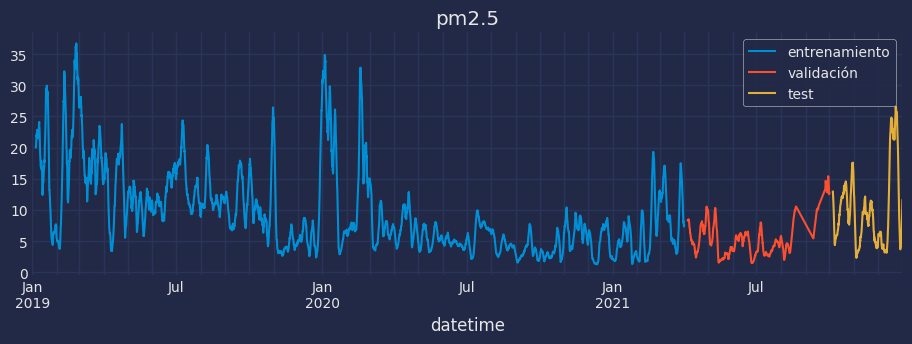

In [34]:
# Plotting pm2.5
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

## LSTM model and ForecasterRnn

Although tensorflow-keras facilitates the process of creating *deep learning* architectures, it is not always trivial to determine the dimensions that an LSTM model should have for forecasting, as these depend on how many time series are being modeled, how many are being predicted, and the length of the prediction horizon.

To improve the user experience and speed up the prototyping, development, and production process, skforecast has the `create_and_compile_model` function, with which, by indicating just a few arguments, the architecture is inferred and the model is created.

+ `series`: Time series to be used to train the model

+ `levels`: Time series to be predicted.
+ 
+ `lags`: Number of time steps to be used to predict the next value.
+ 
+ `steps`: Number of time steps to be predicted.
+ 
+ `recurrent_layer`: Type of recurrent layer to use. By default, an LSTM layer is used.
+ 
+ `recurrent_units`: Number of units in the recurrent layer. By default, 100 is used. If a list is passed, a recurrent layer will be created for each element in the list.
+ 
+ `dense_units`: Number of units in the dense layer. By default, 64 is used. If a list is passed, a dense layer will be created for each element in the list.
+ 
+ `optimizer`: Optimizer to use. By default, Adam with a learning rate of 0.01 is used.
+ 
+ `loss`: Loss function to use. By default, Mean Squared Error is used.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `create_and_compile_model` function is designed to facilitate the creation of the Tensorflow model, however, more advanced users can create their own architectures as long as the input and output dimensions match the use case to which the model will be applied.

</div>

Once the model has been created and compiled, the next step is to create an instance of [ForecasterRnn](https://skforecast.org/latest/api/forecasterrnn). This class is responsible for adding to the *deep learning* model all the functionalities necessary to be used in forecasting problems. It is also compatible with the rest of the functionalities offered by skforecast (backtesting, hyperparameter search, ...).

## 1:1 Problem - Model a single series and predict that same series

In this first scenario, we want to predict the concentration of $O_3$ for the next 1 and 5 days using only its own historical data. It is therefore a scenario in which a single time series is modeled using only its past values. This problem is also called autoregressive prediction.

### One day ahead prediction (Single step forecasting)

First, a single-step forecast is made. To do this, a model is created using the `create_and_compile_model` function, which is passed as an argument to the `ForecasterRnn` class.

This is the simplest example of forecasting with recurrent neural networks. The model only needs a time series to train and predict. Therefore, the `series` argument of the `create_and_compile_model` function only needs a time series, the same one that is to be predicted (`levels`). In addition, since only a single value is to be predicted in the future, the `steps` argument is equal to 1.

In [35]:
# Create model
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 1 # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
 reshape_1 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In this case, a simple LSTM network is used, with a single recurrent layer with 4 neurons and a hidden dense layer with 16 neurons. The following table shows a detailed description of each layer:


| Layer                        | Type            | Output Shape      | Parameters  | Description                                                                                         |
|-----------------------------|-----------------|-------------------|-------------|-----------------------------------------------------------------------------------------------------|
| Input Layer (InputLayer)    | `InputLayer`    | `(None, 32, 1)`   | 0           | This is the input layer of the model. It receives sequences of length 32, corresponding to the number of lags with a dimension at each time step. |
| LSTM Layer (Long Short-Term Memory)| `LSTM`       | `(None, 4)`       | 96          | The LSTM layer is a long and short-term memory layer that processes the input sequence. It has 4 LSTM units and connects to the next layer.  |
| First Dense Layer (Dense)   | `Dense`         | `(None, 16)`      | 80          | This is a fully connected layer with 16 units and uses a default activation function (relu) in the provided architecture.     |
| Second Dense Layer (Dense)  | `Dense`         | `(None, 1)`       | 17          | Another fully connected dense layer, this time with a single output unit. It also uses a default activation function.          |
| Reshape Layer (Reshape)     | `Reshape`       | `(None, 1, 1)`    | 0           | This layer reshapes the output of the previous dense layer to have a specific shape `(None, 1, 1)`. This layer is not strictly necessary, but is included to make the module generalizable to other multi-output forecasting problems. The dimension of this output layer is `(None, steps_to_predict_future, series_to_predict)`. In this case, `steps=1 and levels="o3"`, so the dimension is `(None, 1, 1)`  |
| Total Parameters and Trainable | -           | -                 | 193         | Total Parameters: 193, Trainable Parameters: 193, Non-Trainable Parameters: 0               |




Once the model has been created and compiled, the next step is to create an instance of [ForecasterRnn](https://skforecast.org/latest/api/forecasterrnn). This class is responsible for adding to the *deep learning* model all the functionalities necessary to be used in forecasting problems. It is also compatible with the rest of the functionalities offered by skforecast (backtesting, hyperparameter search, ...).

The forecaster is created from the model and the validation data is passed to it so that it can evaluate the model at each epoch. In addition, a `MinMaxScaler` object is passed to it to standardize the input and output data. This object will be responsible for scaling the input data and the predictions to their original scale.


The `fit_kwargs` are the arguments passed to the `fit` method of the model. In this case, the number of epochs, the batch size, the validation data, and a callback to stop training when the validation loss stops decreasing are passed to it.

In [36]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

/home/ubuntu/anaconda3/envs/skforecast_11_py11/lib/python3.11/site-packages/skforecast/ForecasterRnn/ForecasterRnn.py:224: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/home/ubuntu/anaconda3/envs/skforecast_11_py11/lib/python3.11/site-packages/skforecast/ForecasterRnn/ForecasterRnn.py:249: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7f12954ae190> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 4

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>


The warning indicates that the number of lags has been inferred from the model architecture. In this case, the model has an LSTM layer with 32 neurons, so the number of lags is 32. If a different number of lags is desired, the `lags` argument can be specified in the `create_and_compile_model` function.
To omit the warning, the `lags=lags` and `steps=steps` arguments can be specified in the initialization of the `ForecasterRnn`.

</div>

In [37]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
615/615 [==============================] - 8s 11ms/step - loss: 0.0142 - val_loss: 0.0060
Epoch 2/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 3/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 4/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 5/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 6/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 7/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 8/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 9/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 10/10
615/615 [==============================] - 6s 10ms/step - loss: 0.0054 - val_lo

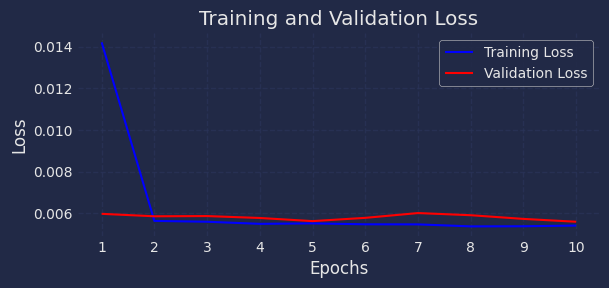

In [38]:
# Track training and overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In *deep learning* models, it is very important to control *overfitting*. To do this, a Keras callback is used to stop training when the value of the cost function, on the validation data, stops decreasing. In this case, the callback does not stop training, as we have only trained for 10 epochs. If the number of epochs is increased, the callback will stop training when the validation loss stops decreasing.

On the other hand, another very useful tool is the plotting of the training and validation loss at each epoch. This allows you to visualize the behavior of the model and detect possible overfitting problems.

In the case of our model, it is observed that the training loss decreases rapidly in the first epoch, while the validation loss is low from the first epoch. From this it can be deduced:

+ The model is not overfitting, as the validation loss is similar to the training loss.

+ The validation error is calculated once the model is trained, so the first value of the validation loss in the first epoch is similar to the training loss in the second epoch.

<p align="center"><img src='../images/overfitting3.jpg'style="width: 350px"></p>


<center><font size='2.5'> <i>Graphical explanation of overfitting. Source: https://datahacker.rs/018-pytorch-popular-techniques-to-prevent-the-overfitting-in-a-neural-networks/.</i></font></center>

Once the forecaster has been trained, predictions can be obtained. In this case, it is a single value since only one step into the future (`step`) has been specified.

In [39]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01,48.8256


To obtain a robust estimate of the predictive capacity of the model, a [backtesting](https://skforecast.org/latest/user_guides/backtesting.html) process is performed. The backtesting process consists of generating a prediction for each observation in the test set, following the same procedure that would be followed if the model were in production, and finally comparing the predicted value with the actual value.

In [40]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Training + Validation Data
    metric="mean_absolute_error",
    verbose=True,
    refit=False,
)

Epoch 1/10
752/752 [==============================] - 7s 8ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 2/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 3/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0054 - val_loss: 0.0077
Epoch 4/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 5/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 6/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 7/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 8/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 9/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 10/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0054 - val_loss: 0.0055

  0%|          | 0/2208 [00:00<?, ?it/s]

In [41]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,54.612850
2021-10-01 01:00:00,59.209904
2021-10-01 02:00:00,63.077805
2021-10-01 03:00:00,63.108265
2021-10-01 04:00:00,53.347530
...,...
2021-12-31 19:00:00,17.557945
2021-12-31 20:00:00,16.834385
2021-12-31 21:00:00,17.608961
2021-12-31 22:00:00,17.318754


In [42]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['o3'], name="predictions", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

In [43]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,5.933167


In [44]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Media de la serie: 54.52
Error (mae) relativo: 10.88 %


El modelo consigue un error de backtesting (mae) de 6.12, lo que se correspondiente con error relativo respecto a la media de la serie del 11.23%.

The model achieves a backtesting error (mae) of 5.9, which corresponds to a relative error with respect to the mean of the series of 10.88%.

### Multi-step forecasting

The next case is to predict the next 5 values of O3 using only its historical data. It is therefore a scenario in which multiple future steps of a single time series are modeled using only its past values.

A similar architecture to the previous one will be used, but with a greater number of neurons in the LSTM layer and in the first dense layer. This will allow the model to have greater flexibility to model the time series.

In [45]:
# Model creation
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 5 # Future time steps to be predicted


model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 32)                1632      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 12197 (47.64 KB)
Trainable params: 12197 (47.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `fit_kwargs` parameter is very useful as it allows you to set any configuration in the model, in this case Keras. In the previous code, the number of training epochs (10) is defined with a batch size of 32. An `EarlyStopping` callback is configured to stop training when the validation loss stops decreasing for 5 epochs (`patience=5`). Other callbacks can also be configured, such as `ModelCheckpoint` to save the model at each epoch, or even Tensorboard to visualize the training and validation loss in real time.

</div>



In [47]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
615/615 [==============================] - 10s 14ms/step - loss: 0.0257 - val_loss: 0.0127
Epoch 2/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 3/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 4/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 5/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 6/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 7/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0115 - val_loss: 0.0125
Epoch 8/10
615/615 [==============================] - 9s 14ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 9/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 10/10
615/615 [==============================] - 8s 14ms/step - loss: 0.0114 - val_l

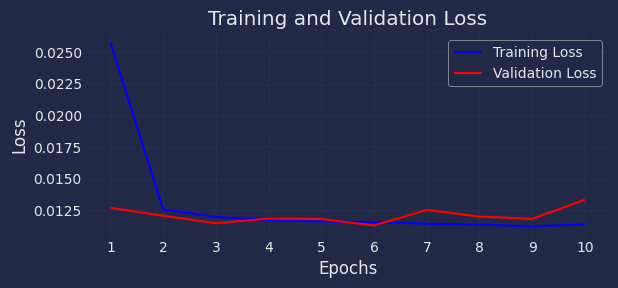

In [48]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

It is anticipated that the prediction will be of lower quality than in the previous case, as the error observed in the different epochs is higher. This has a simple explanation, and that is that the model has to predict 5 values instead of 1. Therefore, the validation error is higher since the loss of 5 values is being calculated instead of 1.

The prediction is made. In this case, there are 5 values since 5 steps into the future (`step`) have been specified.

In [49]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,47.770233
2021-04-01 01:00:00,45.355461
2021-04-01 02:00:00,42.914757
2021-04-01 03:00:00,38.624687
2021-04-01 04:00:00,32.615280


Specific `steps` can be predicted, as long as they are within the prediction horizon defined in the model.

In [50]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,o3
2021-04-01 00:00:00,47.770233
2021-04-01 02:00:00,42.914757


In [51]:
# Backtesting 
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/10
752/752 [==============================] - 11s 14ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 2/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 3/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 4/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0122
Epoch 5/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 6/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 7/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 8/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 9/10
752/752 [==============================] - 10s 13ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 10/10
752/752 [==============================] - 10s 13ms/step - loss: 0.010

  0%|          | 0/442 [00:00<?, ?it/s]

In [52]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,57.380260
2021-10-01 01:00:00,54.153625
2021-10-01 02:00:00,51.160664
2021-10-01 03:00:00,48.591709
2021-10-01 04:00:00,47.653816
...,...
2021-12-31 19:00:00,18.126362
2021-12-31 20:00:00,20.011911
2021-12-31 21:00:00,12.303537
2021-12-31 22:00:00,15.502289


In [53]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['o3'], name="predictions", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

In [54]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,9.548553


In [55]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Media de la serie: 54.52
Error mse relativo: 17.51 %


In this case, the prediction is worse than in the previous case. This is to be expected since the model has to predict 5 values instead of 1.

## N:1 Problems - Multiple time series with single output

In this case, the same series will be predicted, but using multiple time series as predictors. It is therefore a scenario in which past values of multiple time series are used to predict a single time series.

These types of approaches are very useful when multiple time series related to each other are available. For example, in the case of temperature prediction, multiple time series such as humidity, atmospheric pressure, wind speed, etc. can be used.

In this type of problem, the architecture of the neural network is more complex, an additional recurrent dense layer is needed to process the multiple input series. In addition, another hidden dense layer is added to process the output of the recurrent layer. As can be seen, creating the model using `skforecast` is very simple, simply pass a list of integers to the `recurrent_units` and `dense_units` arguments to create multiple recurrent and dense layers.

In [56]:
# Creación del modelo
# ==============================================================================
# Time series used in the training. Now, it is multiseries
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ["o3"] 
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 10)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 32, 100)           44400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dense_6 (Dense)             (None, 64)                3264      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
 reshape_3 (Reshape)         (None, 5, 1)              0   

Once the model has been created and compiled, the next step is to create an instance of [ForecasterRnn](https://skforecast.org/latest/api/forecasterrnn). This class is responsible for adding to the *deep learning* model all the functionalities necessary to be used in forecasting problems. It is also compatible with the rest of the functionalities offered by skforecast (backtesting, hyperparameter search, ...).

In [57]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 4,  
        "batch_size": 128,  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7f12859e5550> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_4'}, 'registered_name': None, 'name': 'input_4', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_3', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'u

In [58]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/4
154/154 [==============================] - 16s 84ms/step - loss: 0.0303 - val_loss: 0.0172
Epoch 2/4
154/154 [==============================] - 12s 81ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 3/4
154/154 [==============================] - 12s 81ms/step - loss: 0.0112 - val_loss: 0.0128
Epoch 4/4
154/154 [==============================] - 12s 81ms/step - loss: 0.0102 - val_loss: 0.0127


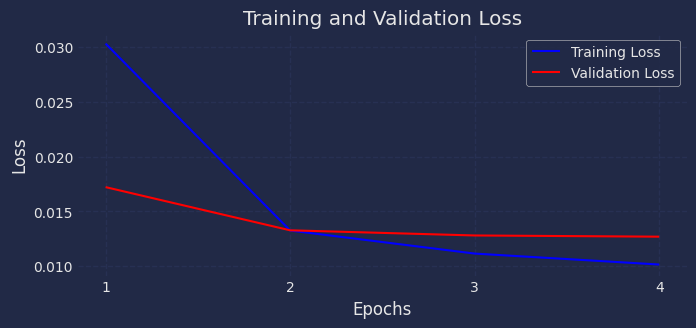

In [59]:
# Trainig and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
forecaster.plot_history(ax=ax)

In [60]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,46.124866
2021-04-01 01:00:00,42.240002
2021-04-01 02:00:00,37.344341
2021-04-01 03:00:00,33.136936
2021-04-01 04:00:00,30.883102


In [61]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/4
188/188 [==============================] - 17s 82ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 2/4
188/188 [==============================] - 15s 80ms/step - loss: 0.0095 - val_loss: 0.0121
Epoch 3/4
188/188 [==============================] - 15s 80ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 4/4
188/188 [==============================] - 16s 84ms/step - loss: 0.0091 - val_loss: 0.0104


  0%|          | 0/442 [00:00<?, ?it/s]

In [62]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,9.97027


In [63]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Media de la serie: 54.52
Error mse relativo: 18.29 %


In [64]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,52.007599
2021-10-01 01:00:00,49.981213
2021-10-01 02:00:00,45.591721
2021-10-01 03:00:00,44.655510
2021-10-01 04:00:00,40.639957
...,...
2021-12-31 19:00:00,22.764130
2021-12-31 20:00:00,12.558327
2021-12-31 21:00:00,7.684178
2021-12-31 22:00:00,6.449364


In [65]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['o3'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['o3'], name="predictions", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Prediction vs real values in the test set",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

When using multiple time series as predictors, it would be expected that the model would be able to predict the target series better. However, in this case, the predictions are worse than in the previous case where only a time series was used as a predictor. This may be because the time series used as predictors are not related to the target series. Therefore, the model is not able to learn any relationship between them.

# N:M Problems - Multiple time series with multiple outputs

In the next and last scenario, multiple time series are predicted using multiple time series as predictors. It is therefore a scenario in which multiple series are modeled simultaneously using a single model. This has special application in many real scenarios, such as the prediction of stock values for several companies based on the stock history, the price of energy and commodities. Or the case of forecasting multiple products in an online store, based on the sales of other products, the price of the products, etc.

In [66]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2'] 
levels = ['pm2.5', 'co', 'no', "o3"] #  Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 10)]          0         
                                                                 
 lstm_5 (LSTM)               (None, 32, 100)           44400     
                                                                 
 lstm_6 (LSTM)               (None, 50)                30200     
                                                                 
 dense_9 (Dense)             (None, 64)                3264      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 20)                660       
                                                                 
 reshape_4 (Reshape)         (None, 5, 4)              0   

In [67]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 100, 
        "batch_size": 128, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x7f1285c66f50> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'model_4', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5'}, 'registered_name': None, 'name': 'input_5', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_5', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 't

The model is trained for 100 epochs with an `EarlyStopping` callback that stops training when the validation loss stops decreasing for 5 epochs (`patience=5`).

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Training the model takes approximately 3 minutes on a computer with 8 cores, and the `EarlyStopping` stops training at epoch 11. These results may vary depending on the hardware used.

In [68]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/100
154/154 [==============================] - 16s 86ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 2/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 3/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 4/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0041 - val_loss: 0.0082
Epoch 5/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 6/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0038 - val_loss: 0.0076
Epoch 7/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 8/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 9/100
154/154 [==============================] - 12s 81ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 10/100
154/154 [==============================] - 12s 81ms/step - l

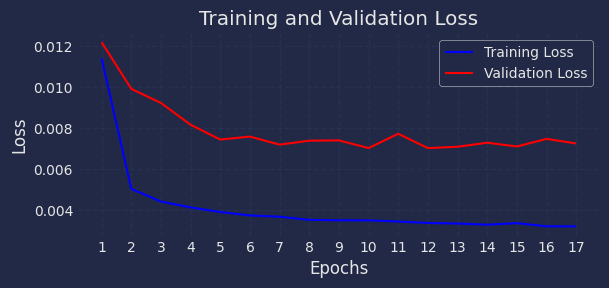

In [69]:
# Trainig and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

There are slight signs of overfitting from epoch 11. This may be because the model is too complex for the problem being solved. Thanks to the Keras callback, the model stops at epoch 16, thus avoiding the model from overfitting further. A good practice would be to modify the architecture of the model to avoid overfitting. For example, the number of neurons in the recurrent and dense layers could be reduced, or a dropout layer could be added to regularize the model.

When the forecaster models multiple time series, by default, predictions are calculated for all of them. However, it is possible to specify the series for which predictions are to be made using the `predict` method.

In [70]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,pm2.5,co,no,o3
2021-04-01 00:00:00,12.820191,0.109160,1.248160,38.645088
2021-04-01 01:00:00,13.549714,0.117340,3.352049,36.810040
2021-04-01 02:00:00,13.048641,0.117833,2.109012,34.212204
2021-04-01 03:00:00,12.001824,0.117750,2.290622,39.499146
2021-04-01 04:00:00,11.314098,0.101048,0.168339,43.080688


The prediction can also be made for specific `steps`, as long as they are within the prediction horizon defined in the model.

In [71]:
# Specific step predictions
# ==============================================================================
forecaster.predict(steps=[1, 5], levels="o3")

,o3
2021-04-01 00:00:00,38.645088
2021-04-01 04:00:00,43.080688


In [72]:
# Backtesting with test data
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/100
188/188 [==============================] - 17s 82ms/step - loss: 0.0032 - val_loss: 0.0071
Epoch 2/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0070
Epoch 3/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0072
Epoch 4/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0073
Epoch 5/100
188/188 [==============================] - 15s 81ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 6/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0031 - val_loss: 0.0084
Epoch 7/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0030 - val_loss: 0.0078


  0%|          | 0/442 [00:00<?, ?it/s]

In [73]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,pm2.5,3.538131
1,co,0.025320
2,no,2.838939
3,o3,11.728837


In [121]:
# Plotting predictions vs real values in the test set
# =============================================================================
fig = px.line(
    data_frame = pd.concat([
                    predictions.melt(ignore_index=False).assign(group="predicciones"),
                    data_test[predictions.columns].melt(ignore_index=False).assign(group="test")
                ]).reset_index().rename(columns={"index": "date_time"}),
    x="date_time",
    y="value",
    facet_row="variable",
    color="group",
    title="Predictions vs real values in the test set",
)

fig.update_layout(
    title="Predicciones vs valores reales en el conjunto de test",
    title="Prediction vs real values in the test set",
    width=800,
    height=850,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0
    )
)

fig.update_yaxes(matches=None)

The backtesting results show that the model is able to capture the pattern of the time series *pm2.5* and *O3*, but not that of the series *CO* and *NO*. This may be because the former have a greater autoregressive behavior, while the future values of the latter do not seem to depend on past values.

It is observed that the backtesting error for the series *O3* is higher than that obtained when only that series was modeled. This may be because the model is trying to model multiple time series at once, making the problem more complex.

## Conclusion

+ Recurrent neural networks allow solving a wide variety of forecasting problems.

+ In the 1:1 and N:1 cases, the model is able to learn patterns of the time series and predict future values with a relative error with respect to the mean close to 5.8%.

+ In the N:M case, the model predicts some of the time series with a higher error than in the previous cases. This may be because some time series are more difficult to predict than others, or simply that the model is not good enough for the problem being tried to solve.

+ Deep learning models have high computational requirements.

+ To achieve a good deep learning model, it is necessary to find the right architecture, which requires knowledge and experience.

+ The more series are modeled, the easier it is for the model to learn the relationships between the series but it can lose precision in the individual prediction of each of them.

+ The use of **skforecast** allows to simplify the modeling process and speed up the prototyping and development process.


## Session Info

In [75]:
import session_info
session_info.show(html=False)

-----
keras               2.15.0
matplotlib          3.7.2
numpy               1.25.2
pandas              2.0.3
plotly              5.17.0
session_info        1.0.0
skforecast          0.12.0
sklearn             1.3.0
-----
IPython             8.14.0
jupyter_client      8.3.0
jupyter_core        5.3.1
jupyterlab          4.0.5
notebook            6.5.4
-----
Python 3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]
Linux-5.15.0-1051-aws-x86_64-with-glibc2.31
-----
Session information updated at 2024-01-14 13:32


## References

Dive into Deep Learning. Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J. (2023). Cambridge University Press. https://D2L.ai

© 2024 Codificando Bits https://www.codificandobits.com/blog/redes-neuronales-recurrentes-explicacion-detallada/

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia.

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov.

Joseph, M. (2022). Modern time series forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and Deep Learning. Packt Publishing.

## Cite as:

**How to cite this document?**

If you use this document or any part of it, we appreciate if you cite it. Thank you very much!

<p style="text-align:left"><font size="3" color="#555">
Deep Learning for time series prediction: Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) by Fernando Carazo and Joaquín Amat Rodrigo, available under the Attribution-NonCommercial-ShareAlike 4.0 International license at https://www.cienciadedatos.net/py54-forecasting-con-deep-learning.html
</font></p>


**How to cite skforecast?**

Zenodo:

<p style="text-align:left"><font size="3" color="#555">
Amat Rodrigo, Joaquin, & Escobar Ortiz, Javier. (2023). skforecast (v0.10.0). Zenodo. https://doi.org/10.5281/zenodo.8382788
</font></p>

APA:

<p style="text-align:left"><font size="3" color="#555">
Amat Rodrigo, J., & Escobar Ortiz, J. (2023). skforecast (Version 0.10.0) [Computer software]. https://doi.org/10.5281/zenodo.8382788
</font></p>

BibTeX:

<p style="text-align:left"><font size="3" color="#555">
@software{skforecast,
author = {Amat Rodrigo, Joaquin and Escobar Ortiz, Javier},
title = {skforecast},
version = {0.10.0},
month = {9},
year = {2023},
license = {BSD-3-Clause},
url = {https://skforecast.org/},
doi = {10.5281/zenodo.8382788}
}
</font></p>

In [1]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

div.admonition.note {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 14px;
}

#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px;
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc-sa.svg" /></a><br />This document created by Fernando Carazo and Joaquín Amat Rodrigo is licensed under a <a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Attribution-NonCommercial-ShareAlike 4.0 International</a>.